In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')



In [3]:
data_frame = pd.read_csv('Data/jumps_input_data.csv', usecols=["Y","U"])
data_frame = data_frame[0:1000]
data_frame.shape
data_frame = pd.read_csv('Data/RNN_MPC_data.csv', usecols=["Y","U"])

In [4]:
display(data_frame.head(10))

,Y,U
0,1.000000,3.419154
1,1.198907,0.500801
2,1.132610,1.527291
3,1.146201,1.803821
4,1.173853,3.277372
5,1.337803,3.434362
6,1.531478,1.931166
7,1.389379,0.691713
8,1.507172,3.421134
9,1.631189,1.482709


In [5]:
# Batch size
batch_size = 100

batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))


/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


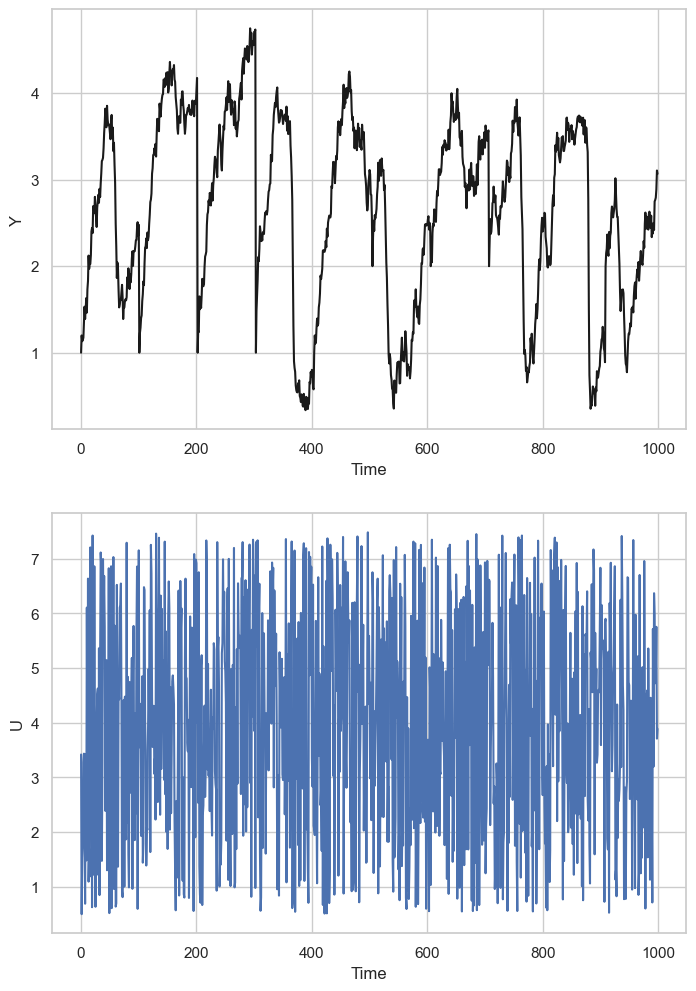

In [6]:
fig = plt.figure(figsize=(18,12))

batch_no_start = 1
batch_no_end = 10

plt.subplot(2, 2, 1)
plt.plot(data_frame[100*(batch_no_start-1):100*(batch_no_end)]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')

plt.subplot(2, 2, 3)
plt.plot(data_frame[100*(batch_no_start-1):100*(batch_no_end)]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [7]:
train_size = batch_size*9
train_set = df.values.astype(float)[:train_size]
test_set = df.values.astype(float)[train_size:]

train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

In [8]:
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+100]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:1]

            inp_data.append((window,label))
        
    return inp_data

In [9]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

print(train_data)

[(tensor([[1.0000, 3.4192]]), tensor([[1.1989]])), (tensor([[1.1989, 0.5008]]), tensor([[1.1326]])), (tensor([[1.1326, 1.5273]]), tensor([[1.1462]])), (tensor([[1.1462, 1.8038]]), tensor([[1.1739]])), (tensor([[1.1739, 3.2774]]), tensor([[1.3378]])), (tensor([[1.3378, 3.4344]]), tensor([[1.5315]])), (tensor([[1.5315, 1.9312]]), tensor([[1.3894]])), (tensor([[1.3894, 0.6917]]), tensor([[1.5072]])), (tensor([[1.5072, 3.4211]]), tensor([[1.6312]])), (tensor([[1.6312, 1.4827]]), tensor([[1.4633]])), (tensor([[1.4633, 6.1052]]), tensor([[1.7333]])), (tensor([[1.7333, 2.6940]]), tensor([[1.8286]])), (tensor([[1.8286, 6.6347]]), tensor([[2.1221]])), (tensor([[2.1221, 1.0953]]), tensor([[1.9702]])), (tensor([[1.9702, 1.6888]]), tensor([[2.0286]])), (tensor([[2.0286, 1.1884]]), tensor([[2.0256]])), (tensor([[2.0256, 7.2052]]), tensor([[2.1297]])), (tensor([[2.1297, 5.3431]]), tensor([[2.4028]])), (tensor([[2.4028, 5.3055]]), tensor([[2.4409]])), (tensor([[2.4409, 0.6280]]), tensor([[2.3820]])),

In [10]:
# from classy import LSTMModel
from classy import LSTMModel
# Creating a model instance, loss function and the optimizer

model = LSTMModel(2, 128, out_size=1, num_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

In [11]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:

epochs = 20
batches = len(batch_data)*batch_size

average_loss = []
show_logs_every_batch = False
hidden=model.init_hidden(batch_size=1)

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,batches,batch_size):

        for seq,label in train_data[bat:bat+batch_size]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            # Make predictions on the current sequence

            y_pred = model(seq, hidden)  
            
            # Compute the loss

            loss = criterion(y_pred, label)
            average_loss.append(loss.item())
            # Perform back propogation and gradient descent
            loss.backward()

            optimizer.step()
        
        model.init_hidden(1)
        
        if (epoch+1)%10 == 0 and show_logs_every_batch:
            print(f'Epoch: {epoch+1}/{epochs}, batch: {bat+batch_size}/{batches}, Loss: {loss.item():10.8f}, Average Loss: {sum(average_loss)/len(average_loss)}')

                      


    if (epoch+1)%10 == 0 and not show_logs_every_batch:
        print(f'Epoch: {epoch+1}/{epochs} Loss: {loss.item():10.8f}, Average Loss: {sum(average_loss)/len(average_loss)}')

learnt_hidden=hidden

Epoch: 10/20 Loss: 0.00066137, Average Loss: 0.49213074812922214
Epoch: 20/20 Loss: 0.03422108, Average Loss: 0.2925784714777019


In [15]:
future = 100

model.eval()
preds = [test_set[0,:1].reshape(-1,1)]

for i in range(future-1):
    seq = test_set[i].reshape(-1,2)
    with torch.no_grad():
        pred = model(seq, hidden)
        preds.append(pred)

        
print(len(preds))       

100


In [16]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

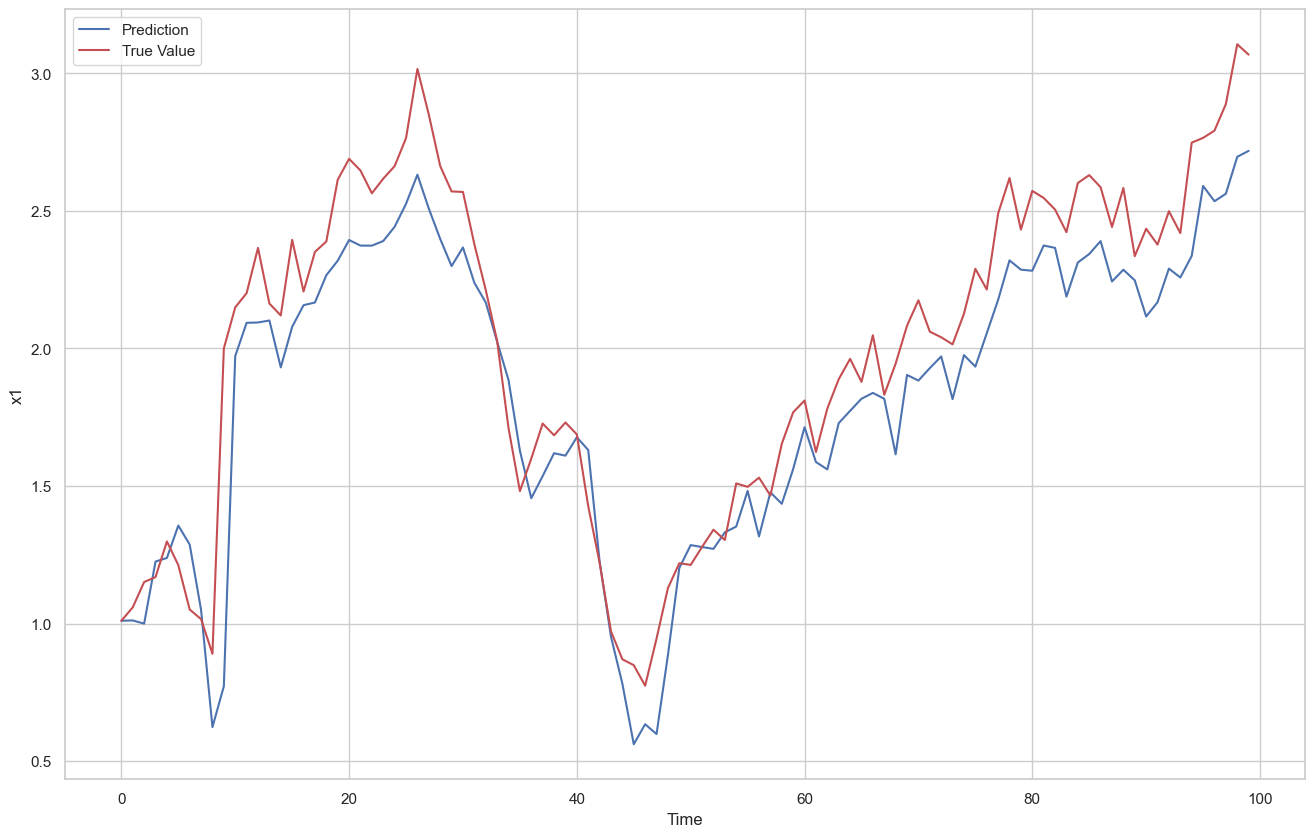

In [17]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [18]:
rmse = np.sqrt(np.sum(np.square((predictions - true_values[:future])))/predictions.size)
display(rmse)

0.24046671231344052

In [19]:
future = 100
hidden = learnt_hidden
preds = [test_set[0,:1].reshape(-1,1)]
prediction_start = 1

for i in range(future-1):
    if i < prediction_start:
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = test_set[i][1]
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        with torch.no_grad():
            pred = model(seq, hidden)
            preds.append(pred)

In [20]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

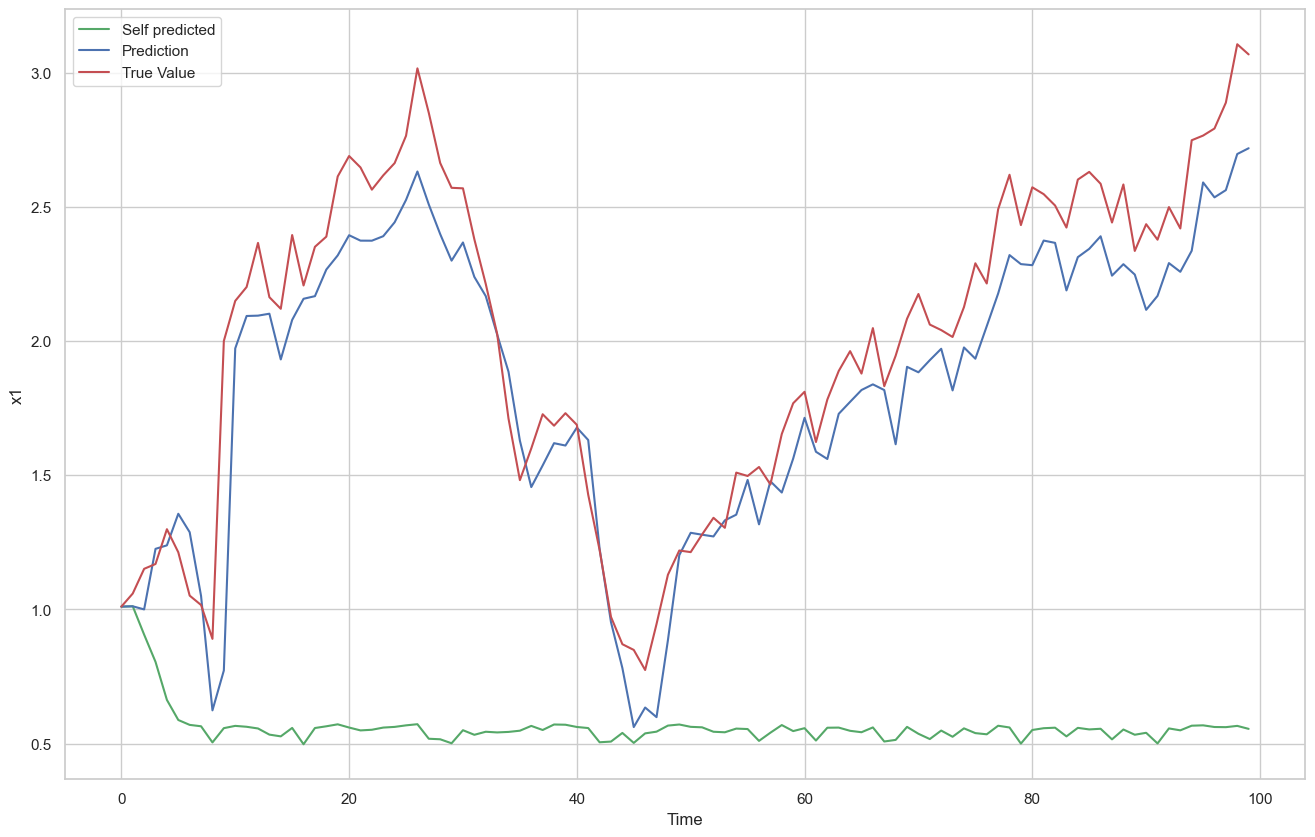

In [21]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:future,0],'g',label='Self predicted')
plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [22]:
rmse = np.sqrt(np.sum(np.square((predictions2 - true_values[:future])))/predictions.size)
display(rmse)

1.572286975786709